In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

from sklearn.datasets import fetch_openml
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix,  classification_report, ConfusionMatrixDisplay
from sklearn import svm
from sklearn.naive_bayes import GaussianNB

## Importing data

In [2]:
mnist = fetch_openml('mnist_784', as_frame=False) # loading 70000 28x28 images (784 features each)

X, y = mnist.data, mnist.target

print(X)
print(X.shape)

print(y)
print(y.shape)

c:\Users\valvs\anaconda3\Lib\site-packages\sklearn\datasets\_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(70000, 784)
['5' '0' '4' ... '4' '5' '6']
(70000,)


## PSNR Generation


$PSNR = 10 \cdot \log_{10}(\frac{MAX^2}{MSE})$

$\frac{PSNR}{10} = \log_{10}(\frac{MAX^2}{MSE})$

$10^\frac{PSNR}{10} = \frac{MAX^2}{MSE}$

$MSE = \frac{MAX^2}{10^\frac{PSNR}{10}}$

The value of MAX is 255 and we want a PSNR of 10dB, so the equation is:

$MSE = \frac{255^2}{10^{\frac{10}{10}}} = 6502.5$

In [3]:
def gen_10db_psnr():
    gaussian_noise = np.random.normal(0, np.sqrt(6502.5), X.shape[1])

    # mse = np.sum(gaussian_noise**2) / X.shape[1]
    # psnr = 10 * np.log10(255**2 / mse)
    # print(f'PSNR = {psnr} dB')

    return gaussian_noise

In [4]:
X_noisy = X.copy()

# Add 10dB PSNR to each image
for i in range(X.shape[0]):
    X_noisy[i] = X_noisy[i] + gen_10db_psnr()

## Plotting example images

Digit = 8


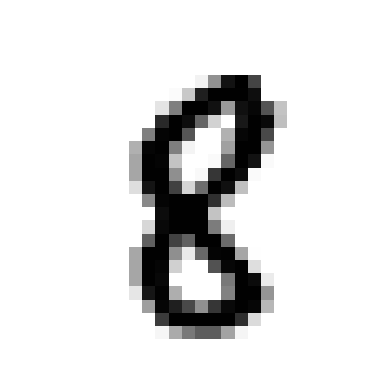

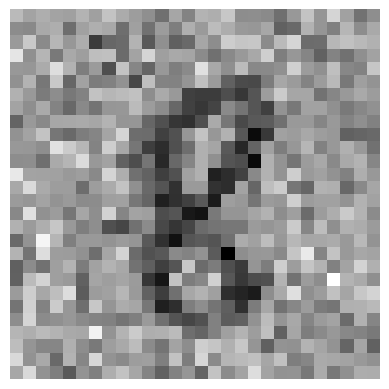

In [5]:
def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

digit_index = np.random.randint(len(X))
# digit_index = 7545

print(f'Digit = {y[digit_index]}')

plot_digit(X[digit_index])
plt.show()

plot_digit(X_noisy[digit_index])
plt.show()


## Separating Data

- Train: 70%
- Validation: 10%
- Test: 20%

In [16]:
# MNIST is already split and into train and test, and is already shuffled!
X_train, X_val, X_test, y_train, y_val, y_test = X[:49000], X[49000:56000], X[56000:], y[:49000], y[49000:56000], y[56000:]

Xn_train, Xn_val, Xn_test = X_noisy[:49000], X_noisy[49000:56000], X_noisy[56000:]

(array([654., 705., 675., 738., 668., 693., 742., 682., 734., 709.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

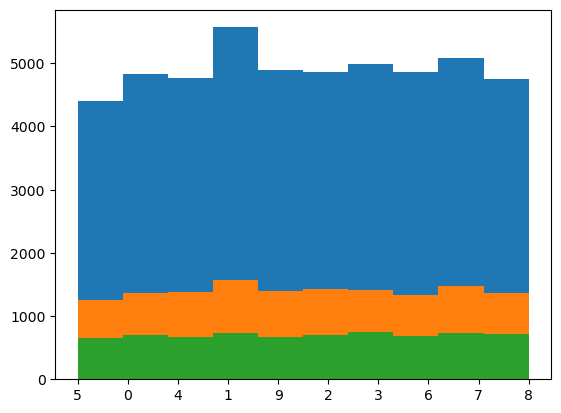

In [7]:
plt.hist(y_train)
plt.hist(y_test)
plt.hist(y_val)

## Naive Bayes

### Training original Dataset

In [8]:
naive_gaussian = GaussianNB() 

param_grid = {
    'var_smoothing': np.logspace(0,-9, num=200)
}

grid_search = GridSearchCV(estimator=naive_gaussian, param_grid=param_grid, cv=5)

grid_search.fit(X_val, y_val)

best_params = grid_search.best_params_

print("Best params: ")
print(best_params)

Best params: 
{'var_smoothing': 0.08214343584919426}


In [20]:
naive_gaussian = GaussianNB(var_smoothing=0.08214343584919426)

naive_gaussian.fit(X_train, y_train)

GaussianNB(var_smoothing=0.08214343584919426)

Predict without noise

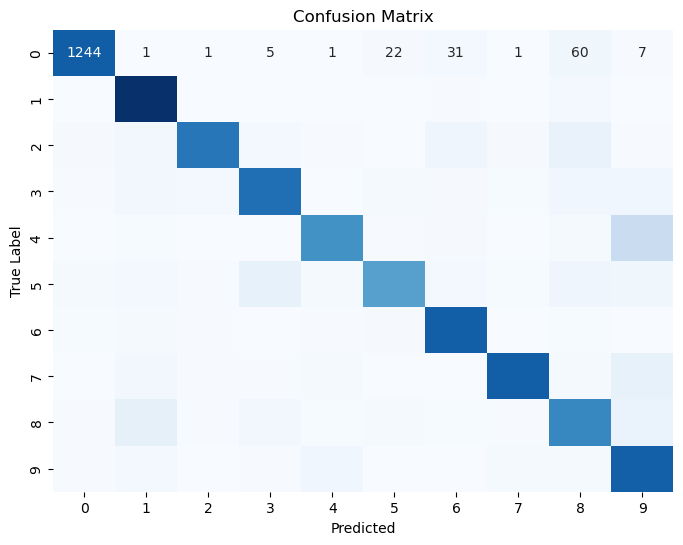

              precision    recall  f1-score   support

           0       0.93      0.91      0.92      1373
           1       0.80      0.97      0.87      1569
           2       0.93      0.77      0.84      1430
           3       0.83      0.81      0.82      1413
           4       0.86      0.68      0.76      1376
           5       0.89      0.68      0.77      1253
           6       0.86      0.93      0.89      1339
           7       0.94      0.83      0.88      1483
           8       0.70      0.74      0.72      1365
           9       0.64      0.88      0.74      1399

    accuracy                           0.82     14000
   macro avg       0.84      0.82      0.82     14000
weighted avg       0.84      0.82      0.82     14000

0.8227857142857142


In [23]:
nb_predict = naive_gaussian.predict(X_test)
cm = confusion_matrix(y_test, nb_predict)

# Plota a matriz de confusão como um mapa de calor (heatmap)
plt.figure(figsize=(8, 6))
sn.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_test, nb_predict))
print(accuracy_score(y_test, nb_predict))

Predict with noise

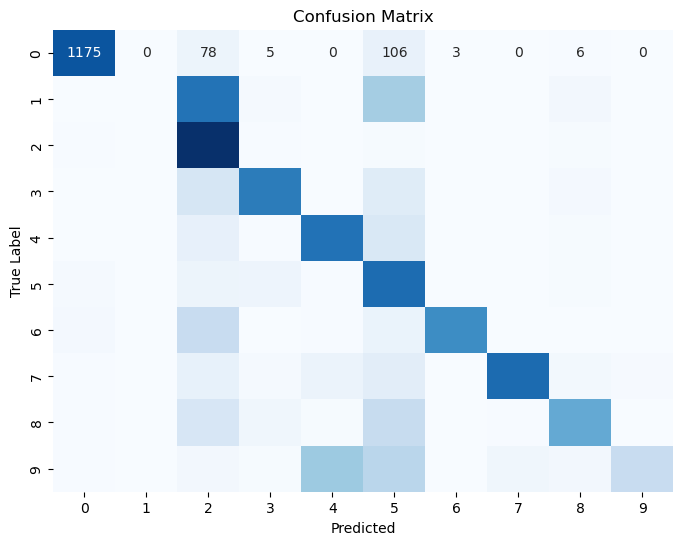

c:\Users\valvs\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\valvs\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.93      0.86      0.89      1373
           1       0.00      0.00      0.00      1569
           2       0.38      0.96      0.55      1430
           3       0.82      0.69      0.75      1413
           4       0.61      0.74      0.67      1376
           5       0.35      0.84      0.50      1253
           6       0.98      0.66      0.79      1339
           7       0.93      0.71      0.81      1483
           8       0.79      0.53      0.63      1365
           9       0.91      0.23      0.37      1399

    accuracy                           0.61     14000
   macro avg       0.67      0.62      0.60     14000
weighted avg       0.67      0.61      0.59     14000

0.6129285714285714


c:\Users\valvs\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [22]:
nb_predict = naive_gaussian.predict(Xn_test)
cm = confusion_matrix(y_test, nb_predict)

# Plota a matriz de confusão como um mapa de calor (heatmap)
plt.figure(figsize=(8, 6))
sn.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_test, nb_predict))
print(accuracy_score(y_test, nb_predict))

In [11]:

print(classification_report(y_test, nb_predict))
print(accuracy_score(y_test, nb_predict))

              precision    recall  f1-score   support

           0       0.93      0.91      0.92      1373
           1       0.80      0.97      0.87      1569
           2       0.93      0.77      0.84      1430
           3       0.83      0.81      0.82      1413
           4       0.86      0.68      0.76      1376
           5       0.89      0.68      0.77      1253
           6       0.86      0.93      0.89      1339
           7       0.94      0.83      0.88      1483
           8       0.70      0.74      0.72      1365
           9       0.64      0.88      0.74      1399

    accuracy                           0.82     14000
   macro avg       0.84      0.82      0.82     14000
weighted avg       0.84      0.82      0.82     14000

0.8227857142857142


### Training with noise

In [17]:
naive_gaussian = GaussianNB() 

param_grid = {
    'var_smoothing': np.logspace(0,-9, num=200)
}

grid_search = GridSearchCV(estimator=naive_gaussian, param_grid=param_grid, cv=5)

grid_search.fit(Xn_val, y_val)

best_params = grid_search.best_params_

print("Best params: ")
print(best_params)

Best params: 
{'var_smoothing': 2.7049597304631315e-05}


In [24]:
naive_gaussian = GaussianNB(var_smoothing=2.7049597304631315e-05)

naive_gaussian.fit(Xn_train, y_train)

GaussianNB(var_smoothing=2.7049597304631315e-05)

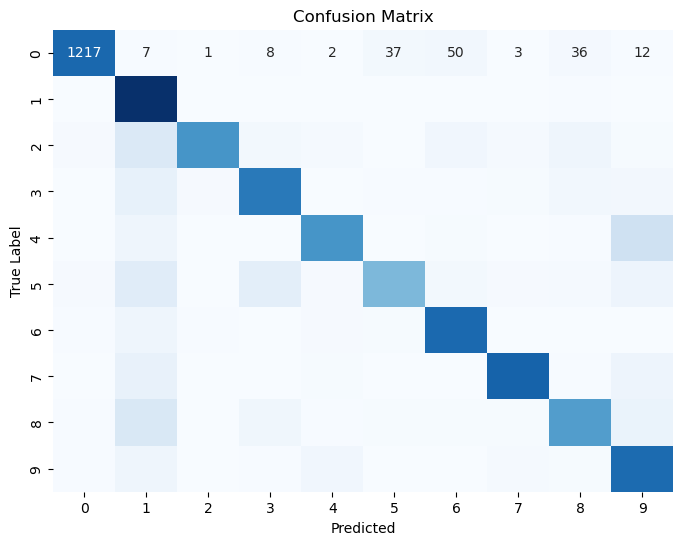

              precision    recall  f1-score   support

           0       0.94      0.89      0.91      1373
           1       0.59      0.99      0.74      1569
           2       0.95      0.66      0.78      1430
           3       0.80      0.79      0.80      1413
           4       0.86      0.69      0.76      1376
           5       0.90      0.57      0.69      1253
           6       0.86      0.90      0.88      1339
           7       0.92      0.84      0.88      1483
           8       0.79      0.66      0.72      1365
           9       0.65      0.86      0.74      1399

    accuracy                           0.79     14000
   macro avg       0.82      0.78      0.79     14000
weighted avg       0.82      0.79      0.79     14000

0.7892142857142858


In [25]:
nb_predict = naive_gaussian.predict(X_test)

cm = confusion_matrix(y_test, nb_predict)

# Plota a matriz de confusão como um mapa de calor (heatmap)
plt.figure(figsize=(8, 6))
sn.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_test, nb_predict))
print(accuracy_score(y_test, nb_predict))

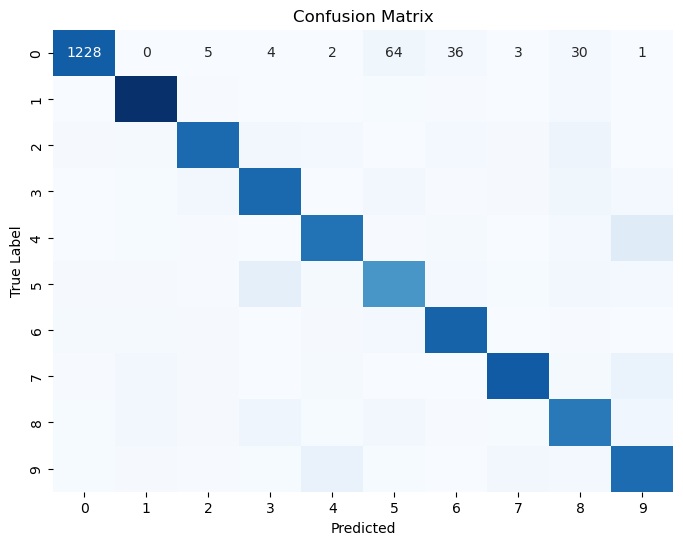

              precision    recall  f1-score   support

           0       0.91      0.89      0.90      1373
           1       0.87      0.95      0.91      1569
           2       0.89      0.81      0.85      1430
           3       0.81      0.83      0.82      1413
           4       0.83      0.81      0.82      1376
           5       0.80      0.73      0.76      1253
           6       0.89      0.90      0.89      1339
           7       0.92      0.84      0.88      1483
           8       0.75      0.79      0.77      1365
           9       0.74      0.82      0.78      1399

    accuracy                           0.84     14000
   macro avg       0.84      0.84      0.84     14000
weighted avg       0.84      0.84      0.84     14000

0.8390714285714286


In [26]:
nb_predict = naive_gaussian.predict(Xn_test)

cm = confusion_matrix(y_test, nb_predict)

# Plota a matriz de confusão como um mapa de calor (heatmap)
plt.figure(figsize=(8, 6))
sn.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_test, nb_predict))
print(accuracy_score(y_test, nb_predict))

## Decision Tree

## Support Vector Machine

### Training original dataset

In [12]:
svm_mnist = svm.SVC()

param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

grid_search = GridSearchCV(estimator=svm_mnist, param_grid=param_grid, cv=5)

grid_search.fit(X_val, y_val)

best_params = grid_search.best_params_

print("Best params: ")
print(best_params)

Best params: 
{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


In [27]:
svm_mnist = svm.SVC(C=10, gamma='scale', kernel='rbf')
svm_mnist.fit(X_train, y_train)

SVC(C=10)

In [30]:
svm_predict = svm_mnist.predict(X_test)

cm = confusion_matrix(y_test, svm_predict)

plt.figure(figsize=(10, 6))
sn.heatmap(cm, cmap=sn.cm.rocket_r, square=True, linewidths=0.1,
                annot=True, fmt='d', annot_kws={"fontsize": 8})
plt.xlabel('Predicted')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_test, svm_predict))
print(accuracy_score(y_test, svm_predict))

: 

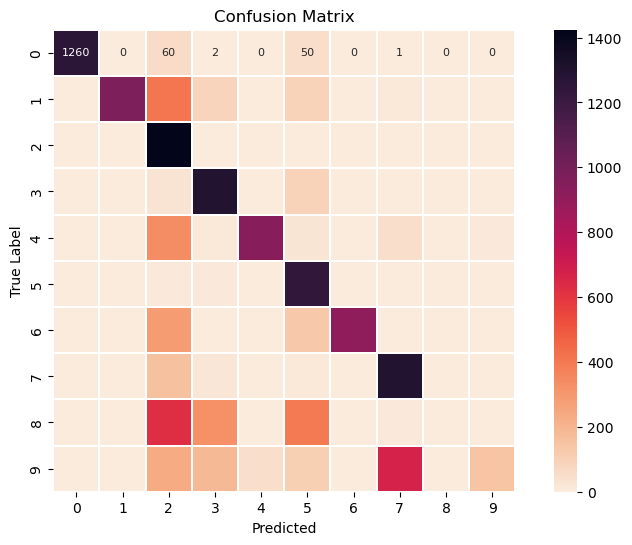

In [ ]:
svm_predict = svm_mnist.predict(Xn_test)

cm = confusion_matrix(y_test, svm_predict)

plt.figure(figsize=(10, 6))
sn.heatmap(cm, cmap=sn.cm.rocket_r, square=True, linewidths=0.1,
                annot=True, fmt='d', annot_kws={"fontsize": 8})
plt.xlabel('Predicted')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_test, svm_predict))
print(accuracy_score(y_test, svm_predict))

### Training with noise

In [ ]:
svm_mnist = svm.SVC()

param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

grid_search = GridSearchCV(estimator=svm_mnist, param_grid=param_grid, cv=5)

grid_search.fit(Xn_val, y_val)

best_params = grid_search.best_params_

print("Best params: ")
print(best_params)

In [ ]:
svm_mnist = svm.SVC(C=10, gamma='scale', kernel='rbf')
svm_mnist.fit(Xn_train, y_train)

In [ ]:
svm_predict = svm_mnist.predict(X_test)

cm = confusion_matrix(y_test, svm_predict)

plt.figure(figsize=(10, 6))
sn.heatmap(cm, cmap=sn.cm.rocket_r, square=True, linewidths=0.1,
                annot=True, fmt='d', annot_kws={"fontsize": 8})
plt.xlabel('Predicted')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
svm_predict = svm_mnist.predict(Xn_test)

cm = confusion_matrix(y_test, svm_predict)

plt.figure(figsize=(10, 6))
sn.heatmap(cm, cmap=sn.cm.rocket_r, square=True, linewidths=0.1,
                annot=True, fmt='d', annot_kws={"fontsize": 8})
plt.xlabel('Predicted')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()